In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from config import get_config
from utils.helper import create_crosschannel_patchtst
from data.data_loader import create_dataloader
from utils.train import train


In [17]:
def train_with_exp_lr(
    model, train_dataloader, optimizer, loss_fn, device, base_lr=1e-6, max_lr=1e-2, num_batches=100
):
    """
    Trains the model with an exponentially increasing learning rate.

    Args:
        model: PyTorch model.
        train_dataloader: DataLoader for training.
        optimizer: Optimizer (Adam, SGD, etc.).
        loss_fn: Loss function (e.g., MSELoss).
        device: CUDA or CPU.
        base_lr: Minimum learning rate.
        max_lr: Maximum learning rate.
        num_batches: Number of batches for exponential increase.

    Returns:
        lr_history: List of learning rates for each batch.
        loss_history: List of training losses for each batch.
    """
    model.to(device)
    model.train()

    lr_history = []
    loss_history = []

    gamma = (max_lr / base_lr) ** (1 / num_batches)  # Exponential growth factor

    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        if batch_idx >= num_batches:
            break  # Stop when reaching num_batches

        # Compute exponentially increasing LR
        lr = base_lr * (gamma ** batch_idx)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        lr_history.append(lr)

        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        print(f"Batch {batch_idx + 1}/{num_batches}: LR = {lr:.6f}, Loss = {loss.item():.6f}")

    return lr_history, loss_history

def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [3]:
config = {
        'epochs': 10,
        'model_name':'xcpatchtst',
        'seq_len': 64,
        'pred_len': 1,
        'batch_size': 8,
        'stride': 4,
        'patch_size': 8,
        'd_model': 128,
        'kernel_size': 3,
        'tickers': ["AAPL", "MSFT", "AMZN"],
        'raw_dataset_dir': 'data/raw',
        'processed_dataset_dir': 'data/processed',
        'ticker_threshold': 4000,
        'dataset_dir': f"/Users/engchongyock/Desktop/XCPatchTST/data/dataset/dataset_2025-03-14.csv"
    }

In [4]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Device: {device}')

Device: mps


In [5]:
in_channels = pd.read_csv(config['dataset_dir']).shape[1]

In [6]:
cross_channel_patchtst_model = create_crosschannel_patchtst(
                                device=device, 
                                in_channels=in_channels, 
                                pred_len=config['pred_len'], 
                                patch_size=config['patch_size'], 
                                stride=config['stride'], 
                                d_model=config['d_model'], 
                                kernel_size=config['kernel_size'],
                                )

[INFO] Created Cross-Channel PatchTST model with the following parameters:
       - in_channels: 37
       - pred_len: 1
       - patch_size: 8
       - stride: 4
       - d_model: 128
       - kernel_size: 3


/Users/engchongyock/Desktop/XCPatchTST/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [7]:
optimizer = optim.Adam(cross_channel_patchtst_model.parameters(), lr=1e-6)  # Start with low LR
loss_fn = nn.MSELoss()

In [8]:
df = pd.read_csv(config['dataset_dir'])
dataloaders = create_dataloader(df, config)

In [9]:
lr_history, loss_history = train_with_exp_lr(
    cross_channel_patchtst_model, dataloaders['train_dataloader'], optimizer, loss_fn, device, base_lr=1e-6, max_lr=1e-2, num_batches=600
)

Batch 1/600: LR = 0.000001, Loss = 27.494942
Batch 2/600: LR = 0.000001, Loss = 23.232157
Batch 3/600: LR = 0.000001, Loss = 40.938595
Batch 4/600: LR = 0.000001, Loss = 22.060678
Batch 5/600: LR = 0.000001, Loss = 16.114927
Batch 6/600: LR = 0.000001, Loss = 29.532644
Batch 7/600: LR = 0.000001, Loss = 44.287403
Batch 8/600: LR = 0.000001, Loss = 18.292320
Batch 9/600: LR = 0.000001, Loss = 19.980368
Batch 10/600: LR = 0.000001, Loss = 80.544746
Batch 11/600: LR = 0.000001, Loss = 42.325230
Batch 12/600: LR = 0.000001, Loss = 10.770561
Batch 13/600: LR = 0.000001, Loss = 34.097378
Batch 14/600: LR = 0.000001, Loss = 23.338261
Batch 15/600: LR = 0.000001, Loss = 30.520813
Batch 16/600: LR = 0.000001, Loss = 21.747797
Batch 17/600: LR = 0.000001, Loss = 18.881916
Batch 18/600: LR = 0.000001, Loss = 19.792521
Batch 19/600: LR = 0.000001, Loss = 16.213070
Batch 20/600: LR = 0.000001, Loss = 23.826986
Batch 21/600: LR = 0.000001, Loss = 21.676920
Batch 22/600: LR = 0.000001, Loss = 24.7999

In [10]:
batch_indices = list(range(len(lr_history)))

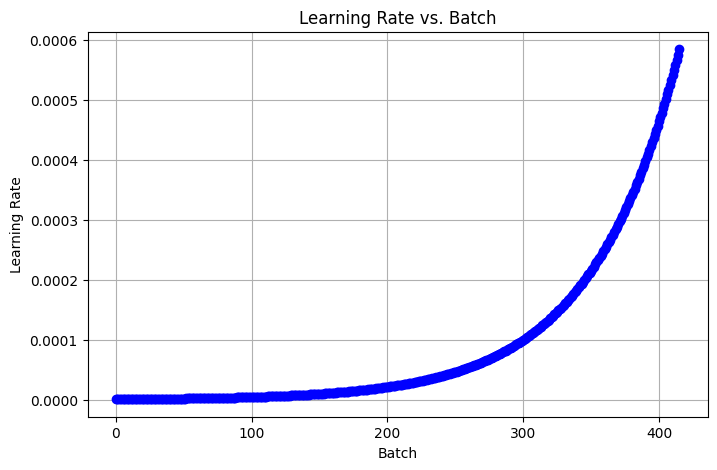

In [11]:
# Plot learning rate against batch index
plt.figure(figsize=(8, 5))
plt.plot(batch_indices, lr_history, marker='o', linestyle='-', color='b')
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate vs. Batch")
plt.grid()
plt.show()


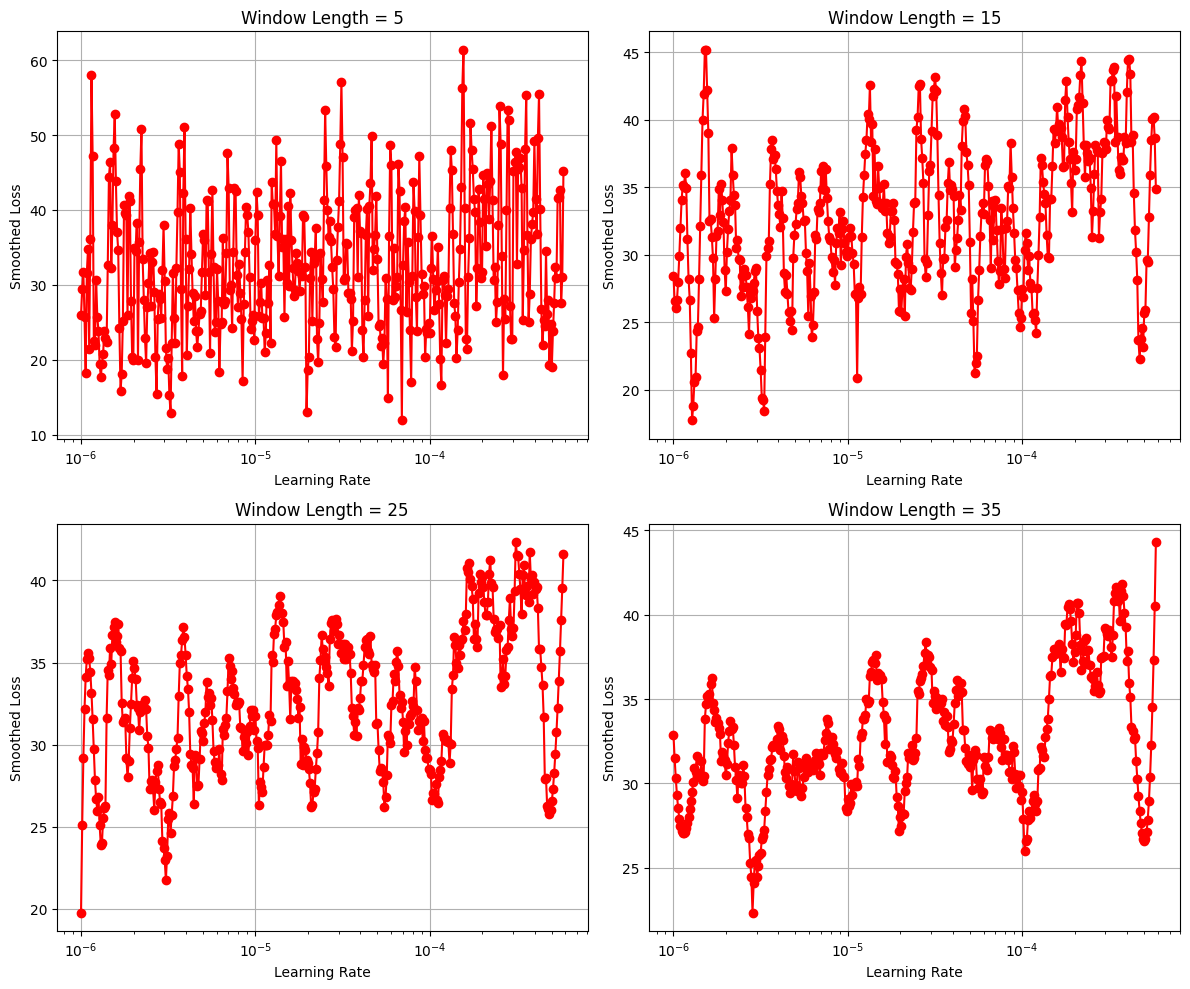

In [21]:
window_lengths = [5, 15, 25, 35]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
axes = axes.ravel()  # Flatten the 2D array of axes

for i, window_length in enumerate(window_lengths):
    # Ensure window_length is odd and does not exceed the length of the data
    window_length = min(window_length, len(loss_history) - 1)
    if window_length % 2 == 0:
        window_length += 1

    # Apply Savitzky-Golay filter
    smoothed_loss = savgol_filter(loss_history, window_length=window_length, polyorder=3)

    # Plot
    axes[i].plot(lr_history, smoothed_loss, marker='o', linestyle='-', color='r')
    axes[i].set_xscale("log")
    axes[i].set_xlabel("Learning Rate")
    axes[i].set_ylabel("Smoothed Loss")
    axes[i].set_title(f"Window Length = {window_length}")
    axes[i].grid()

plt.tight_layout()
plt.show()

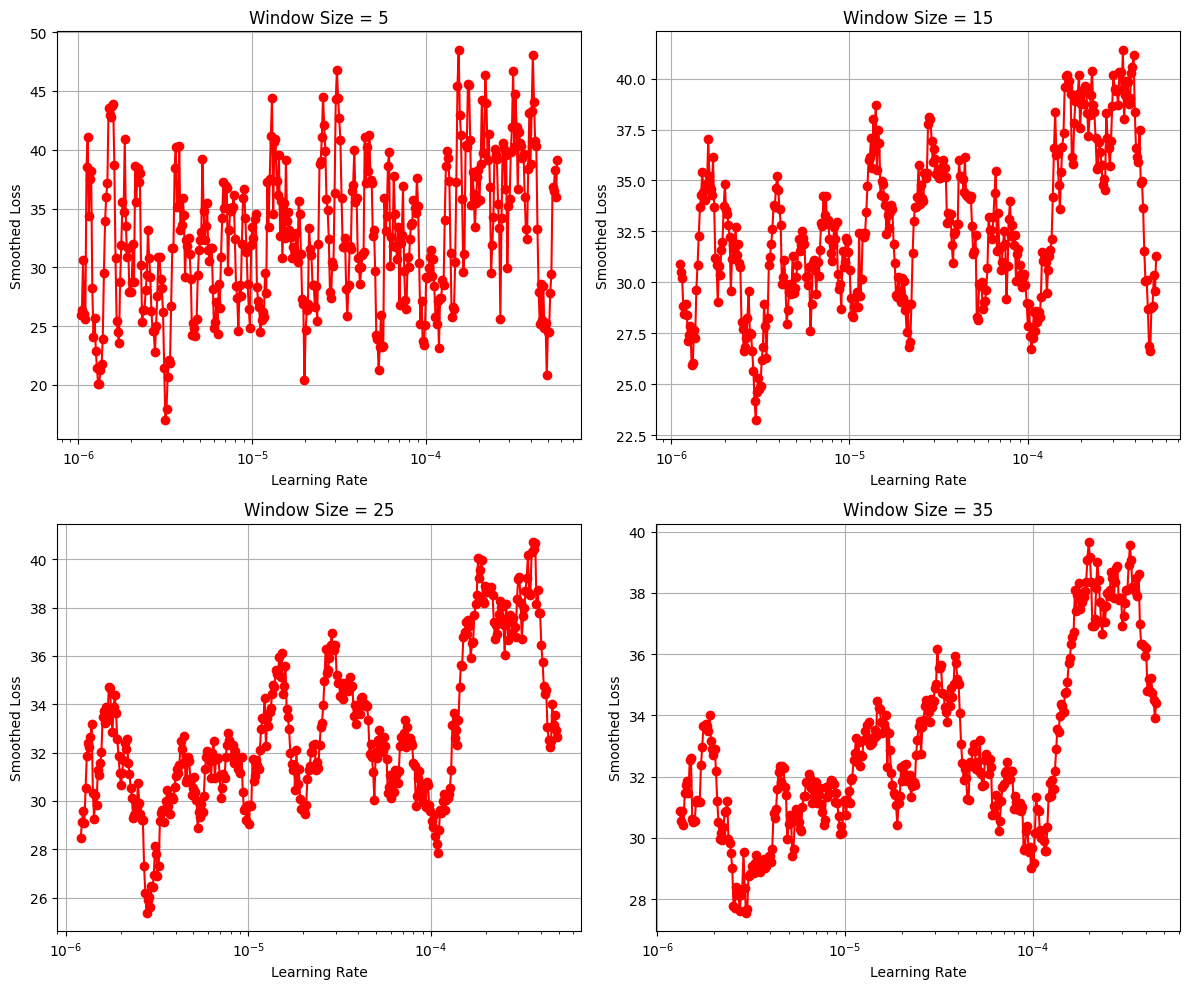

In [18]:
# Define different window sizes to test
window_sizes = [5, 15, 25, 35]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  
axes = axes.ravel()  # Flatten the 2D array of axes

for i, window_size in enumerate(window_sizes):
    # Apply moving average smoothing
    smoothed_loss = moving_average(loss_history, window_size=window_size)
    smoothed_lr = moving_average(lr_history, window_size=window_size)  # Match lengths

    # Plot
    axes[i].plot(smoothed_lr, smoothed_loss, marker='o', linestyle='-', color='r')
    axes[i].set_xscale("log")
    axes[i].set_xlabel("Learning Rate")
    axes[i].set_ylabel("Smoothed Loss")
    axes[i].set_title(f"Window Size = {window_size}")
    axes[i].grid()

plt.tight_layout()
plt.show()